# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [10]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [11]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
#     if prt: print('n,k,cl',n,k,cl)
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [12]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)
        
bell_dict = {}

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [22]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, uf, config):
    '''Randomly sample a color for each cluster'''
    for root in cluster_constraints:
        max_col = cluster_constraints[root]
        cluster_color = np.random.choice((np.arange(1, max_col+1)))
        for site_str in uf.component(root):
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        partition_dict = {}
        if ((no_cl,exact_k) in bell_dict):
            partition_dict = bell_dict[(no_cl,exact_k)]
            if prt: print ("Bell found", (no_cl,exact_k))
        else:
            session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
            partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
            bell_dict[(no_cl,exact_k)] = partition_dict
            if prt: print ("Bell computed", (no_cl,exact_k))
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        if prt: print('Case with field and gamma > 0 or case with gamma = 0')
            
        '''Randomly sample a color for each cluster'''
        config = brute_force_sample (cluster_constraints, uf, config)
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

In [27]:
bell_dict.keys()

dict_keys([(15, 11), (16, 10), (14, 7), (12, 7), (10, 6), (9, 5), (8, 5), (7, 5), (6, 3), (7, 3), (4, 3), (3, 3), (5, 3), (4, 4), (5, 4), (6, 4), (4, 2), (2, 2), (2, 1), (1, 1), (64, 38), (64, 37), (64, 36), (64, 35), (64, 34), (64, 33), (64, 40), (64, 39), (64, 32), (64, 31), (61, 33), (62, 33), (63, 34), (63, 35), (62, 35), (63, 32), (63, 33), (62, 36), (63, 40), (64, 41), (63, 38), (63, 39), (63, 36), (61, 38), (62, 37), (64, 29), (62, 29), (62, 32), (61, 32), (63, 37), (62, 38), (64, 43), (62, 39), (60, 38), (61, 37), (62, 34), (62, 42), (63, 41), (61, 36), (14, 10), (13, 9), (11, 7), (9, 7), (8, 7), (3, 2), (3, 1), (7, 4), (6, 5), (8, 4)])

## Experiment routine

In [23]:
only_averages = False
prt = True
N, no_cols = 4, 16
gamma = 2    # strength of preference for low no. of cols
J = 1        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)
curr_params = {}
curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
param_name = "Alpha"

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)
for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

session.terminate()

lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
edge probabilities: [0.86466472 0.13533528]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[15 10 14  2]
 [12 14 14 10]
 [ 5  3  8 11]
 [ 1  2  7  7]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 11
assigned no. cols (eta_lambda): 11
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 1  1  0  1]
 [ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]]



Bell found (13, 9)
partition_dict {(8, 0, 0, 0, 1): 1287, (7, 1, 0, 1, 0): 25740, (7, 0, 2, 0, 0): 17160, (6, 2, 1, 0, 0): 180180, (5, 4, 0, 0, 0): 135135}
partition_p: [1287, 25740, 17160, 180180, 135135]
partition_p: [0.003579952267303103, 0.07159904534606205, 0.0477326968973747, 0.5011933174224343, 0.37589498806682575]
chosen partition:
(5, 4, 0, 0, 0)
chosen partition:
[1, 1, 1, 1, 1, 2, 2, 2, 2]
colors for clusters:
[ 2 14  8  2  4 14  3  1  5  5 16  9  8]
config:
[[ 2 14 14  8]
 [ 2  4 14 14]
 [ 3  1  5  5]
 [16  9  8  5]]

-------------------- iter 5 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 9
assigned no. cols (eta_lambda): 9
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (

[1 9]
config:
[[1 1 1 9]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

-------------------- iter 30 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  0  0  1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 1  0  1 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 2]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Case with no field and gamma > 0
prob_k: [16, 240]
prob_k: [0.0625 0.9375]
exact

clusters formed by bonds (eta_edge):
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Case with no field and gamma > 0
prob_k: [16]
prob_k: [1.]
exact number of colors to use in configuration:
1
Bell found (1, 1)
partition_dict {(1,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(1,)
chosen partition:
[1]
colors for clusters:
[2]
config:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]

-------------------- iter 65 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 1
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  0  0  1]
 [ 0  0  1  1]
 [ 1  0  0  0]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 1  0  0 -1]
 [ 1  1  0 -1]
 [ 0  0  0 -1]]
probab

prob_k: [3.05101294e-05 6.86477911e-03 1.60178179e-01 8.32926532e-01]
exact number of colors to use in configuration:
4
Bell found (5, 4)
partition_dict {(3, 1): 10}
partition_p: [10]
partition_p: [1.0]
chosen partition:
(3, 1)
chosen partition:
[1, 1, 1, 2]
colors for clusters:
[10 15 16 14 10]
config:
[[10 15 15 15]
 [16 15 15 15]
 [14 14 15 10]
 [14 15 15 15]]

final config:
[[10 15 15 15]
 [16 15 15 15]
 [14 14 15 10]
 [14 15 15 15]]


## Full simulation

In [16]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [17]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nparam), np.zeros(nparam)
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            curr_params['gamma'] = param
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            curr_params['alpha'] = param
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            curr_params['J'] = param
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_.png", format="png")
    
#     plt.show()
    
    return params, avg_c, std_c

## J (edges / neighbor interaction) with multiple Gamma

In [18]:
def plot_multiple (params, avg_c, std_c, params2, param_name, param_name2):
    f = plt.figure(figsize=(18, 5)) 
    
    for i in range(len(params)):
        plt.errorbar(params[i], avg_c[i], std_c[i], linestyle='solid', capsize=3, marker='o',
                     label=(str(param_name2)+" = "+str(params2[i])) )

    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.legend()
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(N*N) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_.png", format="png")

    plt.show()

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[ 3 24 11  8 16]
 [ 6 16 14  8  5]
 [ 3 20 10  8 23]
 [11 17  4  5 10]
 [ 7 25 12 20  4]]
equilibration step: 0
1 num. cols: 18.0 avg. sites per col: 1.3888888888888888
101 num. cols: 16.07920792079208 avg. sites per col: 1.5685386305615894
Final configuration:
[[19  2  1 11  7]
 [19 19 19 10 22]
 [ 6  1 15 13 21]
 [ 1  5 12  9  4]
 [ 2 10  8  8 13]]
Final averages: 16.085714285714285 1.5676472118312006
Final stds: 1.4807609736971359 0.14721877500082262
--

1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 3.8217821782178216 avg. sites per col: 8.019212635549266
Final configuration:
[[7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]]
Final averages: 3.723809523809524 8.54705215419501
Final stds: 1.7861650224792627 4.407095472117363
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[ 1  2 23 24 24]
 [ 2 23 23 20  6]
 [ 1  1 11 12  4]
 [ 4  9  3 25 24]
 [ 7 10 23  2  7]]
equilibration step: 0
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 2.405940594059406 avg. sites per col: 12.39686468646865
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 2.3523809523809525 12.87698412698413
Final stds: 0.8616811075251445 6.523645384719202
------------------------------------------------------------------

1 num. cols: 13.0 avg. sites per col: 1.9230769230769231
101 num. cols: 12.990099009900991 avg. sites per col: 1.951103521793679
Final configuration:
[[15  7 22 22 25]
 [18  5 10 23 14]
 [17 19 25  8 22]
 [23 17 16 18 13]
 [ 6 17  6  5 25]]
Final averages: 13.00952380952381 1.9475938394005623
Final stds: 1.533717786762971 0.221369470213648
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[ 5 25 10 20 15]
 [11  2  2  2 25]
 [16 12 13  8  5]
 [24 14  3  2 12]
 [18 24  6  2 11]]
equilibration step: 0
1 num. cols: 12.0 avg. sites per col: 2.0833333333333335
101 num. cols: 13.366336633663366 avg. sites per col: 1.8950057780503333
Final configuration:
[[12 25  4 19 13]
 [15  3  3 24 19]
 [ 3 21 24 22 24]
 [16 25 15 25 12]
 [10  4 20  7  6]]
Final averages: 13.457142857142857 1.883330954759527
Final stds: 1.5183234577813054 0.2292238033739

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.702970297029703 avg. sites per col: 16.46039603960396
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.6761904761904762 16.785714285714285
Final stds: 0.5254519704431895 6.098213559459856
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities: [0.95021293 0.04978707]
Initial configuration
[[22  2  3  8 17]
 [ 5  2 10 15 17]
 [ 6  7  5 24 13]
 [19 10 17 13 20]
 [17  9 14 12 16]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.108910891089109 avg. sites per col: 23.638613861386137
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.1047619047619048 23.69047619047619
Final stds: 0.3062463845869243 3.8280798073365543
---------------------------------------------------------------------------

1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 9.752475247524753 avg. sites per col: 2.5945719571957193
Final configuration:
[[10 11 17  9 22]
 [ 1 16 11 16 17]
 [ 5 16  5  6 22]
 [ 9  7 11 11 16]
 [ 7  7  5 11  9]]
Final averages: 9.761904761904763 2.5909692159692157
Final stds: 1.0647942749998998 0.2777131293081378
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
Initial configuration
[[17 14 18 20  6]
 [24 10  3 21 12]
 [13 10 11 11 21]
 [21 22 11 19  1]
 [25 20 19 16 24]]
equilibration step: 0
1 num. cols: 8.0 avg. sites per col: 3.125
101 num. cols: 10.049504950495049 avg. sites per col: 2.5329456022525343
Final configuration:
[[ 3 25 15  6 23]
 [23  6  3 15 21]
 [13 13 13 13 24]
 [ 9  2 11 21 15]
 [25 25 13 24 11]]
Final averages: 10.085714285714285 2.5230325230325232
Final stds: 1.3317677883838723 0.33977604425691016
-------

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[22 22 22 22 22]
 [22 22 22 22 22]
 [22 22 22 22 22]
 [22 22 22 22 22]
 [22 22 22 22 22]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[ 1 16  1  8 13]
 [17 25 20 10  7]
 [ 8  6  1  2  7]
 [12 24  9 12 22]
 [24  5 25 16 20]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

18  - param: 1.8
edge probabilities: [0.97267628 0.02732372]
Initial confi

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

7  - param: 0.7
edge probabilities: [0.75340304 0.24659696]
Initial configuration
[[ 3 14 14 17 14]
 [14 21  3 13  6]
 [15  3  5 23 15]
 [ 9 19 12  5 20]
 [ 1  1 17  1  5]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 8 11 22 19 15]


1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilities: [9.99756404e-01 2.43595864e-04]
Initial configuration
[[ 7 23 18  2  5]
 [ 7 23 10  2 15]
 [ 7 14  2 13 18]
 [16 20  7 11  8]
 [19  1 14 14 23]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 5.0 avg. sites per col: 5.0
Final configuration:
[[10 22 22 10 22]
 [14 10  2 14 14]
 [13 10 13  2 13]
 [14 14 10 13 14]
 [22 22 14  2  2]]

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide



Final averages: 5.0 5.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[ 9 22 24 24 12]
 [16 22  5 11 24]
 [11 13  3  6 14]
 [18 10  9  4 10]
 [ 1  8  1 17 21]]
equilibration step: 0
1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 5.0 avg. sites per col: 5.0
Final configuration:
[[ 6 23 23 10 10]
 [25  6 23 25 10]
 [10 23 10  6  6]
 [10 25 10  6  6]
 [23 10  5 10 23]]
Final averages: 5.0 5.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[20 18 22  2 19]
 [18 20 15 21 15]
 [13  5 22 13  4]
 [23 12  3 19 13]
 [21  2 18 22 16]]
equilibration step: 0
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[ 1 11 14 12 21]
 [ 9  3 20 14  7]
 [16  9 11 22  2]
 [18  6  4 12  9]
 [15  1  8 18 21]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configu

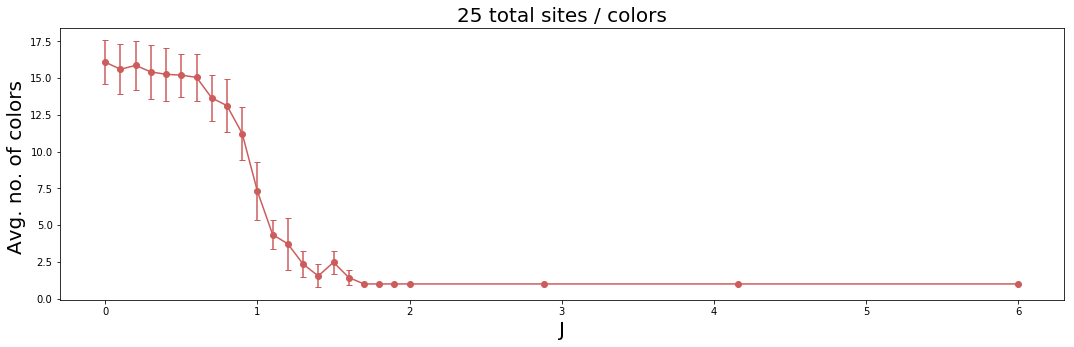

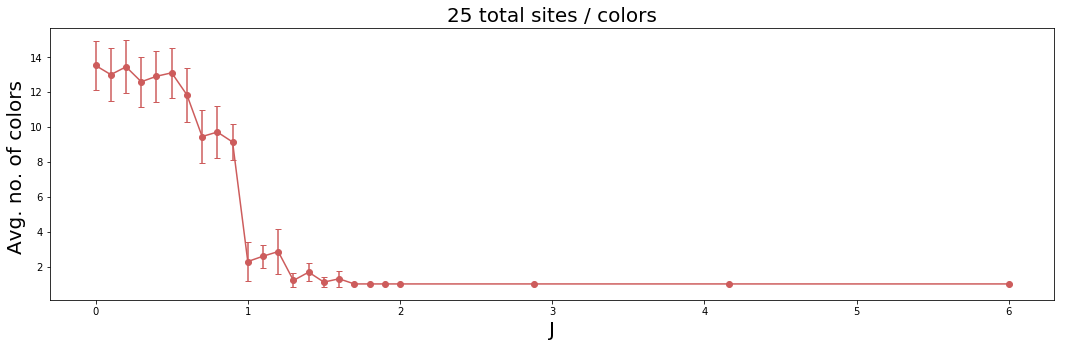

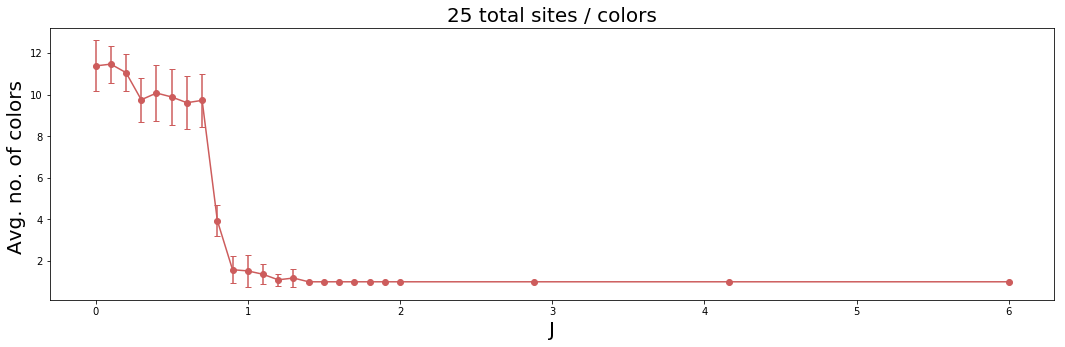

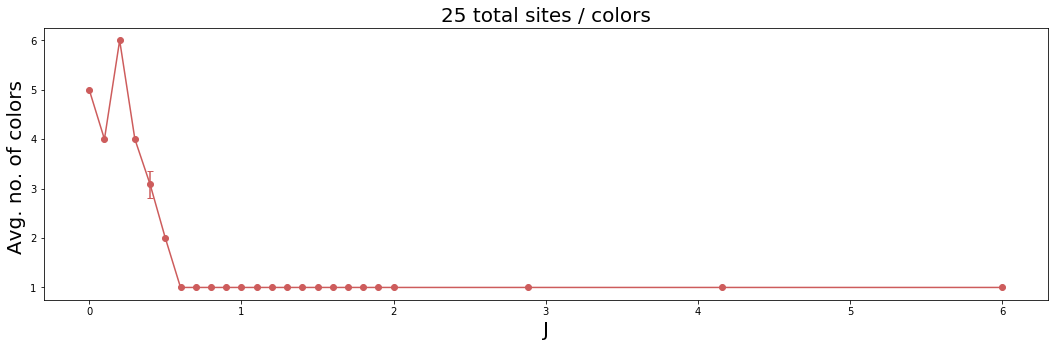

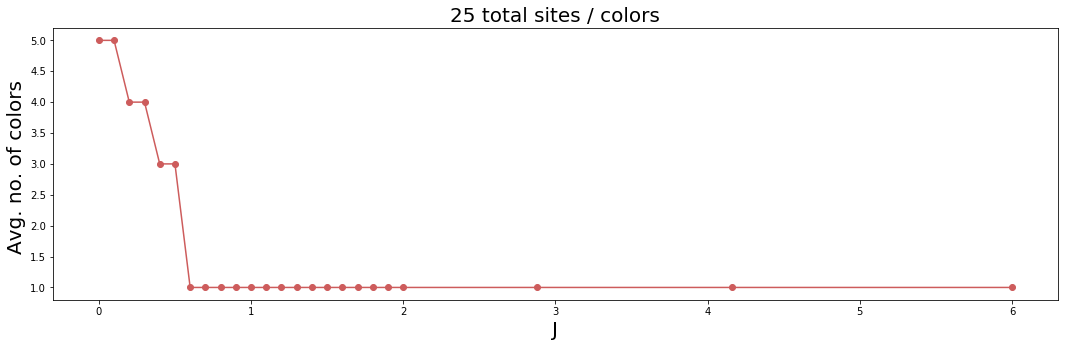

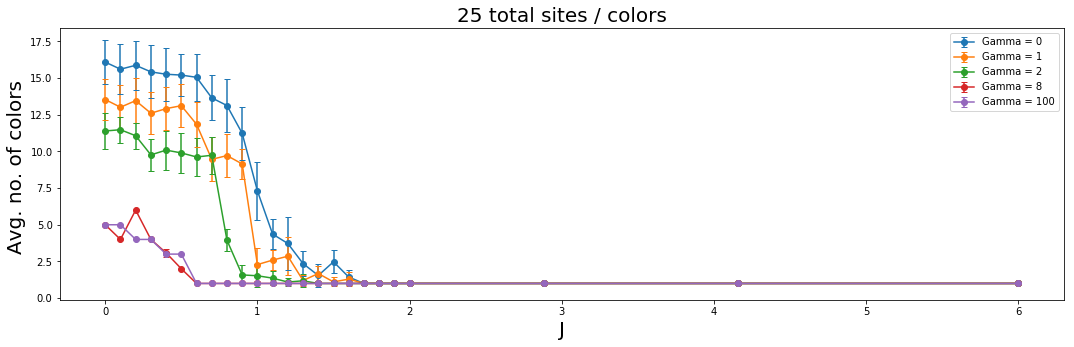

In [97]:
eq_steps = 505          #  number of MC sweeps for equilibration
mc_steps = 105          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 5

k=0
ngamma = 5
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[20  7 11 21  7]
 [ 4 12 21  7  1]
 [21 19 19  4  7]
 [13 24 23  5 14]
 [24  7  9 20 22]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 1.7857142857142858
101 num. cols: 16.04950495049505 avg. sites per col: 1.571403644634187
201 num. cols: 16.074626865671643 avg. sites per col: 1.5697821072890397
301 num. cols: 15.9568

401 num. cols: 14.86783042394015 avg. sites per col: 1.7036991028555295
501 num. cols: 14.920159680638722 avg. sites per col: 1.697178335171701
601 num. cols: 14.910149750415973 avg. sites per col: 1.6987727143997289
701 num. cols: 14.954350927246791 avg. sites per col: 1.6934641112258912
801 num. cols: 14.945068664169789 avg. sites per col: 1.6950471508809504
901 num. cols: 14.93007769145394 avg. sites per col: 1.6970678972715774
1001 num. cols: 14.883116883116884 avg. sites per col: 1.7022733090720839
Final configuration:
[[12 25 10  5  9]
 [ 3 18  5 18 10]
 [21 12  2 13 17]
 [ 2 14 10 17 22]
 [23 11  9  7  4]]
Final averages: 14.891542288557213 1.7014182460528524
Final stds: 1.6990421970966938 0.20081633938509655
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[12  6 21  3  6]
 [ 7 24 19 24 14]
 [ 6 14 20  7  2]
 [ 3 21 18  1 21

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 4.166666666666667
101 num. cols: 5.287128712871287 avg. sites per col: 5.629723686654377
201 num. cols: 6.497512437810945 avg. sites per col: 4.506216213305763
301 num. cols: 5.840531561461794 avg. sites per col: 5.170778142123652
401 num. cols: 5.72568578553616 avg. sites per col: 5.126285116933499
501 num. cols: 6.429141716566866 avg. sites per col: 4.661036595916847
601 num. cols: 6.422628951747088 avg. sites per col: 4.687692599506248
701 num. cols: 6.1455064194008555 avg. sites per col: 4.968995084009352
801 num. cols: 6.390761548064919 avg. sites per col: 4.807876528382153
901 num. cols: 6.665926748057713 avg. sites per col: 4.606360697509428
1001 num. cols: 7.104895104895105 avg. sites per col: 4.381545028398171
Final configuration:
[[ 2 12 17 24 23]
 [ 2 19 20 25 23]
 [ 2 16 20 23 23]
 [16  3 23 23 23]
 [16 23 23 23 23

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.1293532338308458 avg. sites per col: 23.383084577114428
301 num. cols: 1.212624584717608 avg. sites per col: 22.3421926910299
401 num. cols: 1.2668329177057356 avg. sites per col: 21.706151288445557
501 num. cols: 1.4830339321357286 avg. sites per col: 20.088988689288144
601 num. cols: 1.4026622296173046 avg. sites per col: 20.906128674431546
701 num. cols: 1.3851640513552068 avg. sites per col: 20.99084640989067
801 num. cols: 1.3433208489388264 avg. sites per col: 21.4133374947982
901 num. cols: 1.3052164261931187 avg. sites per col: 21.81141324454313
1001 num. cols: 1.2747252747252746 avg. sites per col: 22.129953379953403
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.27363184

GAMMA: 1 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 1.93367146e-07
 7.11357975e-08 2.61693974e-08 9.62718331e-09 3.54164282e-09
 1.30289758e-09 4.79309234e-10 1.76328013e-10 6.48674509e-11
 3.77513454e-11]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[24  7  7  9  5]
 [21  3  2 19  8]
 [ 8 18  6  9 20]
 [22 14 10 16 19]
 [ 5  3  2  3  9]]
equilibration step: 0
equilibration step: 1000
equilibration step

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 13.0 avg. sites per col: 1.9230769230769231
101 num. cols: 12.089108910891088 avg. sites per col: 2.0940624282208455
201 num. cols: 11.950248756218905 avg. sites per col: 2.113573270289683
301 num. cols: 12.375415282392026 avg. sites per col: 2.0497356664788735
401 num. cols: 12.239401496259351 avg. sites per col: 2.0775042093987386
501 num. cols: 12.165668662674651 avg. sites per col: 2.0949856651248
601 num. cols: 12.299500831946755 avg. sites per col: 2.072164368153892
701 num. cols: 12.315263908701855 avg. sites per col: 2.067979289202115
801 num. cols: 12.319600499375781 avg. sites per col: 2.0681416043830576
901 num. cols: 12.233074361820199 avg. sites per col: 2.0828652090077187
1001 num. cols: 12.222777222777223 avg. sites per col: 2.085268266678758
Final configuration:
[[ 7  5 13 14 18]
 [17  5  5 20 21]
 [ 5 10  5 17  7]
 [ 7  1  9  9 18]
 [ 9  1 18 20 18]]
Final averages: 12.2248756218905

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 2.3267326732673266 avg. sites per col: 13.345709570957093
201 num. cols: 2.2487562189054726 avg. sites per col: 13.061774461028197
301 num. cols: 2.548172757475083 avg. sites per col: 11.940753045404229
401 num. cols: 2.5885286783042396 avg. sites per col: 11.54984562403515
501 num. cols: 2.3013972055888225 avg. sites per col: 13.876889078984886
601 num. cols: 2.3643926788685525 avg. sites per col: 14.06932559490796
701 num. cols: 2.4465049928673324 avg. sites per col: 13.791706292597887
801 num. cols: 2.3957553058676653 avg. sites per col: 14.15426896934389
901 num. cols: 2.3895671476137625 avg. sites per col: 14.20373967196944
1001 num. cols: 2.387612387612388 avg. sites per col: 14.087648462648504
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0042796005706134 avg. sites per col: 24.946504992867332
801 num. cols: 1.00374531835206 avg. sites per col: 24.95318352059925
901 num. cols: 1.0033296337402886 avg. sites per col: 24.958379578246394
1001 num. cols: 1.002997002997003 avg. sites per col: 24.962537462537462
Final configuration:
[[18 18 18 18 18]
 [22 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0049751243781095 24.937810945273633
Final stds: 0.07035888370015399 0.8794860462519246
---------------------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 2.272727272727273
101 num. cols: 9.227722772277227 avg. sites per col: 2.736273627362733
201 num. cols: 10.348258706467663 avg. sites per col: 2.4713898594495527
301 num. cols: 10.631229235880399 avg. sites per col: 2.394458623694498
401 num. cols: 10.82294264339152 avg. sites per col: 2.349282748285236
501 num. cols: 11.013972055888223 avg. sites per col: 2.3136585636585574
601 num. cols: 11.05657237936772 avg. sites per col: 2.3070073298858578
701 num. cols: 11.119828815977176 avg. sites per col: 2.290771520443406
801 num. cols: 11.184769038701623 avg. sites per col: 2.276933082176513
901 num. cols: 11.146503884572697 avg. sites per col: 2.281090779980887
1001 num. cols: 11.188811188811188 avg. sites per col: 2.27001783320465
Final configuration:
[[20  6 23 11 21]
 [17 19 12 20 21]
 [17 19 16 12  7]
 [ 7  6 12 19 19]
 [20  

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 9.148514851485148 avg. sites per col: 2.754025402540252
201 num. cols: 8.82587064676617 avg. sites per col: 2.891722014856338
301 num. cols: 8.564784053156146 avg. sites per col: 3.034721369438976
401 num. cols: 8.71072319201995 avg. sites per col: 2.965434572354775
501 num. cols: 8.7125748502994 avg. sites per col: 2.954163130061343
601 num. cols: 8.820299500831947 avg. sites per col: 2.9174028966042376
701 num. cols: 8.89586305278174 avg. sites per col: 2.8939558816520408
801 num. cols: 9.012484394506867 avg. sites per col: 2.8613353285638077
901 num. cols: 8.90899001109878 avg. sites per col: 2.8939241175645285
1001 num. cols: 8.724275724275724 avg. sites per col: 2.9639854539954444
Final configuration:
[[ 1 23 23 23  2]
 [ 1 23 23 23  6]
 [ 6  2 23 23  4]
 [25  8 25  8  8]
 [25  5  2  2  1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.1782178217821782 avg. sites per col: 22.77227722772277
201 num. cols: 1.472636815920398 avg. sites per col: 19.46517412935324
301 num. cols: 1.3322259136212624 avg. sites per col: 21.096345514950173
401 num. cols: 1.2493765586034913 avg. sites per col: 22.069825436408983
501 num. cols: 1.2574850299401197 avg. sites per col: 21.9311377245509
601 num. cols: 1.2146422628951747 avg. sites per col: 22.44176372712147
701 num. cols: 1.1840228245363766 avg. sites per col: 22.80670470756063
801 num. cols: 1.2172284644194757 avg. sites per col: 22.419891801914268
901 num. cols: 1.2097669256381798 avg. sites per col: 22.49815020347761
1001 num. cols: 1.1888111888111887 avg. sites per col: 22.748085248085243
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]

301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
Initial configuration
[[14  6 23 25 19]
 [11  8  6 16  7]
 [ 5 24 23 16 15]
 [16 23 16 21  5]
 [15  3  4 21 16]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites 

201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.095577746077033 avg. sites per col: 6.130527817403709
801 num. cols: 4.2084893882646695 avg. sites per col: 5.989388264669164
901 num. cols: 4.296337402885682 avg. sites per col: 5.879578246392897
1001 num. cols: 4.3666333666333665 avg. sites per col: 5.791708291708292
Final configuration:
[[17 22  6  6  6]
 [17 14  6  6 22]
 [ 6 22 22  2 14]
 [22  6 22  2  2]
 [17 22 22  2 17]]
Final averages: 4.369154228855721 5.788557213930348
Final stds: 0.4825757807574465 0.6032197259468082
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[17 15  2 19 19]
 [10  1  2 18 15]
 [ 6 21 21  8 20]
 [24  6 23  3 23]
 [2

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[24 21 18 23  7]
 [ 6 17 25 24

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[18  8  6  8 22]
 [11 14 15  9 19]
 [ 8  3 13  9 23]
 

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.0 avg. sites per col: 6.25
801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[ 2 18  3  3 18]
 [18 18 18  3 11]
 [ 3 11  2 18  2]
 [18 18 18  3 11]
 [ 3 11 11 18 11]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[13 10 10 25 13]
 [ 9  1 10  9

401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 1  8  6  6  2]
 [ 2  7 23 10 15]
 [ 8 17  8 17 12]
 [10 16 24 10 12]
 [ 5 25 23 19 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 nu

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[ 7 12 16  6 11]
 [22 10 23 11  3]
 [ 1 20 12 20  8]
 [1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



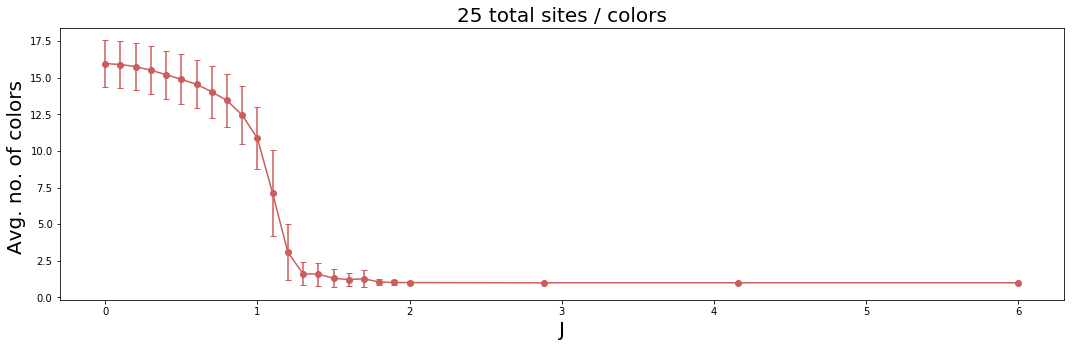

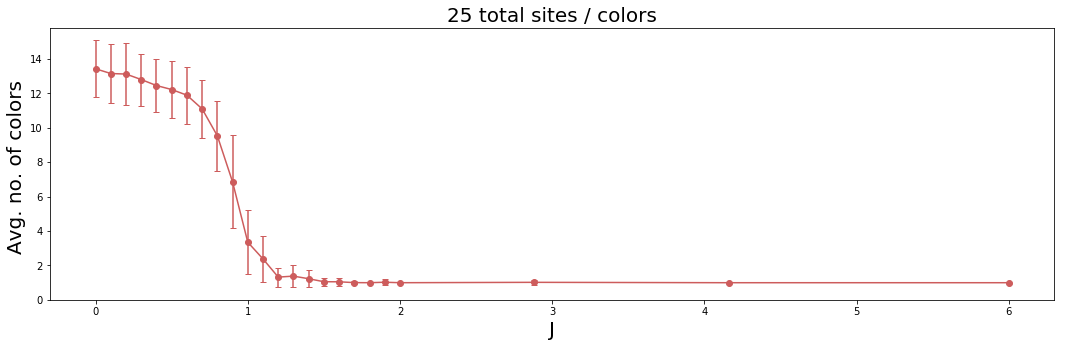

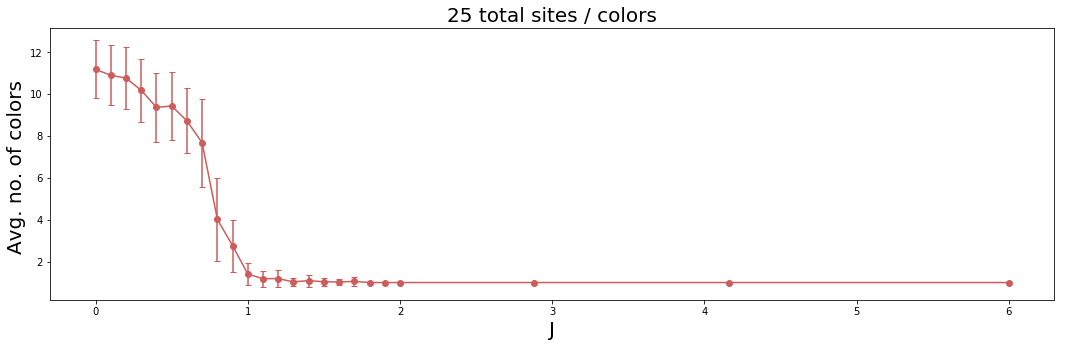

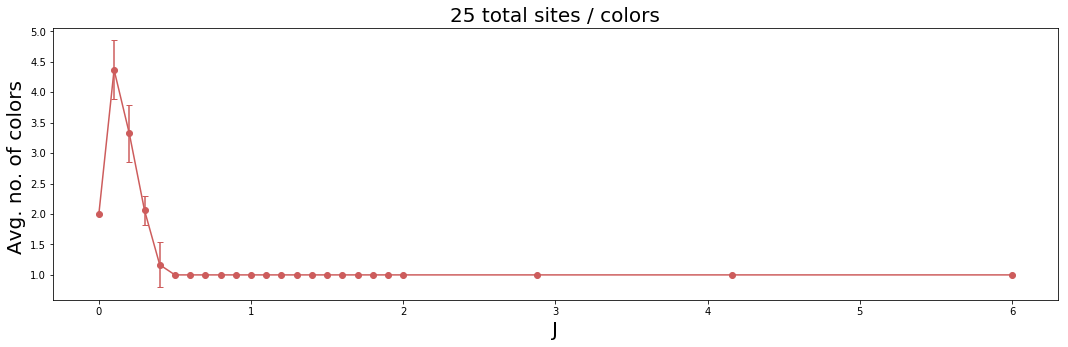

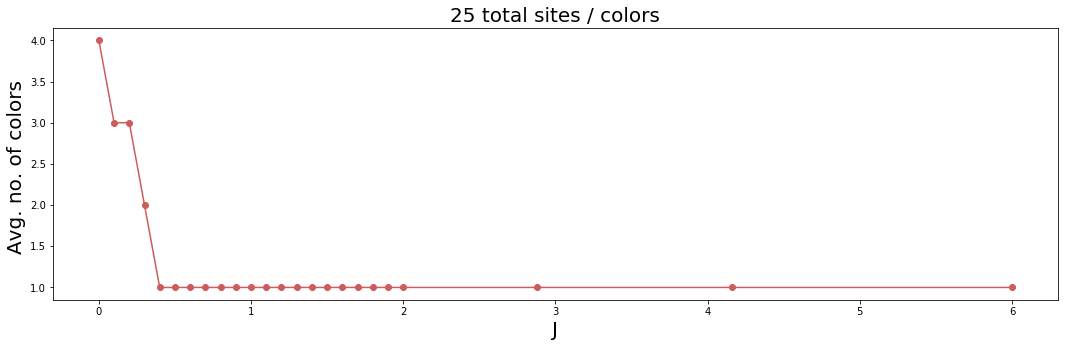

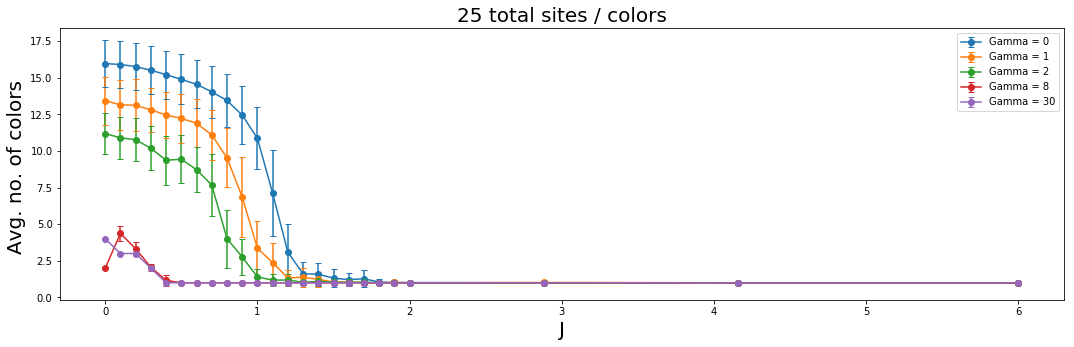

In [99]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 5

k=0
ngamma = 5
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

In [ ]:
eq_steps = 55          #  number of MC sweeps for equilibration
mc_steps = 15          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 6

k=0
ngamma = 6
params, avg_c, std_c = [], [], []
gammas = [0,1,2,4,8,16]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[ 6  1  5 11 22 13]
 [19 24 26 11  5 22]
 [13 17 11 13 22 33]
 [11  1 33 19 16 20]
 [33 34 20 31 14  3]
 [ 9 23 28 32 21 25]]
equilibration step: 0
1 num. cols: 24.0 avg. sites per col: 1.5
Final configuration:
[[33  5 25 18 33  4]
 [ 6  6 35 19 29 26]
 [35 17  6  8  3 35]
 [ 6  8 22 18  5 13]
 [34 17 23  4 30 15]
 [18  9 11 36  3 26]]
Final averages: 22.733333333333334 1.5910536420101637
Fi

1 num. cols: 19.0 avg. sites per col: 1.894736842105263
Final configuration:
[[17 14 28 28 21  9]
 [18 18 28 28 14 13]
 [17  1 34 28  1 14]
 [ 1  1 32 19 19 13]
 [ 1  1  1 24 24 24]
 [28 12  1 24 24 24]]
Final averages: 16.6 2.1933814173442654
Final stds: 1.7048949136725897 0.24218794170153007
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[ 7 30  7 13 32 10]
 [ 8 31 12 29 29 23]
 [12 28 22 22 35  5]
 [32 26  1  1 16 19]
 [16  3 20  5 15 32]
 [22 22  9  3 14 19]]
equilibration step: 0
1 num. cols: 17.0 avg. sites per col: 2.1176470588235294
Final configuration:
[[13 13 13 13 10 13]
 [13 13 13 13 13 13]
 [13 13 13 13 16 13]
 [13 13 26 31 31 11]
 [13 18 17 17 17 17]
 [27  9 35  2 17 17]]
Final averages: 13.866666666666667 2.650017629429394
Final stds: 1.892675942210452 0.3990233349539106
--------------------------------------------

equilibration step: 0
1 num. cols: 20.0 avg. sites per col: 1.8
Final configuration:
[[ 7  4 21 31 17 32]
 [ 2  9 22  5 12  3]
 [ 5 12 24  5  3 26]
 [20  3 21  8  9  3]
 [22 33 31  8 12  3]
 [21 32 23 26 33  2]]
Final averages: 18.8 1.9269143446852428
Final stds: 1.5999999999999999 0.14237063371535458
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[20 25  5 11 16 31]
 [30 19  4 28 13  8]
 [21 27 18 17 27 19]
 [ 4 26 32  8  3  7]
 [28 31 11 14 27 15]
 [20 33 10 16  2 14]]
equilibration step: 0
1 num. cols: 19.0 avg. sites per col: 1.894736842105263
Final configuration:
[[35 28 26  4 23  9]
 [36 17 26 28  9 21]
 [23  5 14 24 12 35]
 [19  3  4 15 10 10]
 [13 21 36 24  4 11]
 [15 12  5  3 19 34]]
Final averages: 19.8 1.8237776258828893
Final stds: 1.1075498483890767 0.10016967837335354
-------------------------------------------------

Initial configuration
[[11 21 20 19  6 36]
 [35 33  9 17 34 13]
 [12 32 16 23 15 33]
 [32 13 23  2  4 18]
 [25 24 26 21 14 34]
 [34 28 27 10 19 27]]
equilibration step: 0
1 num. cols: 7.0 avg. sites per col: 5.142857142857143
Final configuration:
[[20 20 20 20 20 15]
 [20 20 20 20 20 20]
 [20 20 20 20 20 20]
 [20 20 20 20 20 20]
 [20 20 20 31 31  9]
 [29 20 20 31 31  3]]
Final averages: 6.466666666666667 5.614285714285715
Final stds: 0.618241233033047 0.4961072958338667
------------------------------------------------------------------------------------------------------------------------

14  - param: 1.4
edge probabilities: [0.93918994 0.06081006]
Initial configuration
[[ 5  2 27 30 29 15]
 [ 1 14 33 27 11 31]
 [10 21  9 20 32  9]
 [22 16 31  2 29 20]
 [ 3  5 23  4  8  4]
 [21 18 31 29 20 23]]
equilibration step: 0
1 num. cols: 5.0 avg. sites per col: 7.2
Final configuration:
[[36 36 36 36 36 28]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36

1 num. cols: 15.0 avg. sites per col: 2.4
Final configuration:
[[17 16 36 36 23 11]
 [ 5  5 16 33 36 33]
 [ 3 12 12  3 36 30]
 [35 16  3 16 20 18]
 [17 33 35  5  3 23]
 [22 33 20 35 22  5]]
Final averages: 14.2 2.537142857142858
Final stds: 0.3999999999999999 0.06857142857142867
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[ 8 11 12 14 26 22]
 [19 17 15 31 33 23]
 [ 4  9 17  5 22  9]
 [16 13 28 10 24 25]
 [ 8 34 35 16 10 17]
 [18 10 36  1 13 35]]
equilibration step: 0
1 num. cols: 15.0 avg. sites per col: 2.4
Final configuration:
[[21 19 21 33 19 19]
 [35 21 34 17 19 24]
 [ 8  8 25 28 35 10]
 [33 35  8 28 33 19]
 [31 34 34 31 17 28]
 [34 33 11 33 24 32]]
Final averages: 14.6 2.468571428571429
Final stds: 0.4898979485566356 0.08398250546685196
---------------------------------------------------------------------------------------

In [ ]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 6

k=0
ngamma = 6
params, avg_c, std_c = [], [], []
gammas = [0,1,2,4,8,16]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")